<a href="https://colab.research.google.com/github/SIrRob525/HSE-NES-Data-Science-Project-2024/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ публикаций в области компьютерных наук на основе базы данных DBLP

**О проекте DBLP:** "DBLP (Digital Bibliography & Library Project) — это проект, который представляет собой электронную библиографическую базу данных по информатике. Он содержит информацию о научных публикациях, конференциях и других событиях в области информатики. Он поддерживается сообществом исследователей и разработчиков, которые вносят свой вклад в его развитие. База данных постоянно обновляется и расширяется, что делает её ценным источником информации для учёных, студентов и всех, кто интересуется информатикой." (Yandex GPT 3 Pro, ред.). Официальный сайт проекта: https://dblp.uni-trier.de/

TODO

### 1. Преобразование XML-дампа в SQL базу данных

Для начала, скачаем XML-дамп c официального сайта проекта.

In [ ]:
!wget https://dblp.org/xml/dblp.xml.gz
!gzip -d dblp.xml.gz
!wget https://dblp.org/xml/dblp.dtd

--2024-06-06 19:24:14--  https://dblp.org/xml/dblp.xml.gz
Resolving dblp.org (dblp.org)... 192.76.146.204
Connecting to dblp.org (dblp.org)|192.76.146.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870720986 (830M) [application/x-gzip]
Saving to: ‘dblp.xml.gz’

dblp.xml.gz         100%[===================>] 830.38M  8.34MB/s    in 2m 43s  

2024-06-06 19:26:58 (5.11 MB/s) - ‘dblp.xml.gz’ saved [870720986/870720986]

--2024-06-06 19:27:47--  https://dblp.org/xml/dblp.dtd
Resolving dblp.org (dblp.org)... 192.76.146.204
Connecting to dblp.org (dblp.org)|192.76.146.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13134 (13K) [application/xml-dtd]
Saving to: ‘dblp.dtd’

dblp.dtd            100%[===================>]  12.83K  --.-KB/s    in 0.04s   

2024-06-06 19:27:48 (333 KB/s) - ‘dblp.dtd’ saved [13134/13134]



Работать с XML сложно, более того, он не влезает в оперативную память. Я решил итеративно считать элементы файла и записать их в SQL базу данных. Это было не так тривиально, как кажется, так как было превышение RAM в силу особенностей функции `iterparse`. Помог разобраться ответ со StackOverflow https://stackoverflow.com/questions/12160418/why-is-lxml-etree-iterparse-eating-up-all-my-memory.

Будте осторожны! Запись в базу длится около 35 минут, так как дамп содержит более 10 миллионов записей. Для удобства я сохранил файл базы данных на Диск и далее работал с ним.

In [18]:
# WARNING: runs for ~35 minutes.

from lxml import etree as ET
import sqlite3
from tqdm import tqdm
import re

def dblp_xml_to_database(input_file, output_file, batch_size=100000):
    conn = sqlite3.connect(output_file)
    cur = conn.cursor()
    cur.execute("""CREATE TABLE IF NOT EXISTS dblp(
        type varchar(50),
        key varchar(50),
        mdate varchar(50),
        author varchar(50),
        editor varchar(50),
        title varchar(50),
        booktitle varchar(50),
        pages varchar(50),
        year varchar(50),
        address varchar(50),
        journal varchar(50),
        volume varchar(50),
        number varchar(50),
        month varchar(50),
        url varchar(50),
        ee varchar(50),
        cdrom varchar(50),
        cite varchar(50),
        publisher varchar(50),
        note varchar(50),
        crossref varchar(50),
        isbn varchar(50),
        series varchar(50),
        school varchar(50),
        chapter varchar(50),
        publnr varchar(50),
        stream varchar(50),
        rel varchar(50),
        ref,
        sup,
        sub,
        i,
        tt
    );""")

    element_count = 0
    for i, element in tqdm(enumerate(ET.iterparse(input_file, events=["start", "end"], dtd_validation=True))):
        if element[0] == "start" and element[1].tag in \
              set("article|inproceedings|proceedings|book|incollection|phdthesis|mastersthesis|www|person|data".split("|")):
            row = {"type" : element[1].tag}
            if element[1].attrib.get("key") is not None:
                row["key"] = element[1].attrib.get("key")
            if element[1].attrib.get("mdate") is not None:
                row["mdate"] = element[1].attrib.get("mdate")
        elif element[0] == "start" and element[1].tag != "dblp":
            if element[1].text is not None:
                row[element[1].tag] = element[1].text
        elif element[0] == "end" and element[1].tag in \
              set("article|inproceedings|proceedings|book|incollection|phdthesis|mastersthesis|www|person|data".split("|")):
            keys_str = ", ".join(row.keys())
            values = [re.sub(r'"', r'""', v) for v in row.values()]
            values_str = '"' + '", "'.join(values) + '"'
            cur.execute(f'''INSERT INTO dblp({keys_str})
                            VALUES ({values_str});''')
            element_count += 1

            if element_count % batch_size == 0:
                conn.commit()
                print(f"\nBatch {element_count // batch_size} was inserted.")

            element[1].clear()
            while element[1].getprevious() is not None:
                del element[1].getparent()[0]

    conn.commit()
    print("\nFinal commit.")


    conn.close()
    print(f"\nTotal of {element_count} elements was inserted.")

dblp_xml_to_database("dblp.xml", "dblp.db")

2168245it [00:22, 82045.72it/s]


Batch 1 was inserted.


4412926it [00:42, 137638.95it/s]


Batch 2 was inserted.


6674550it [01:03, 88980.27it/s]


Batch 3 was inserted.


9027758it [01:35, 97297.98it/s]


Batch 4 was inserted.


11312906it [02:02, 84687.85it/s]


Batch 5 was inserted.


13580729it [02:30, 95089.03it/s]


Batch 6 was inserted.


15833217it [02:55, 76073.91it/s]


Batch 7 was inserted.


18117438it [03:11, 83090.08it/s]


Batch 8 was inserted.


20413777it [03:35, 70161.47it/s]


Batch 9 was inserted.


22722185it [03:57, 152679.83it/s]


Batch 10 was inserted.


25029535it [04:18, 79019.83it/s]


Batch 11 was inserted.


27337494it [04:47, 55933.06it/s]


Batch 12 was inserted.


29612858it [05:13, 75000.39it/s]


Batch 13 was inserted.


31887695it [05:39, 86446.13it/s]


Batch 14 was inserted.


34175579it [06:03, 100382.62it/s]


Batch 15 was inserted.


36462615it [06:19, 73498.18it/s]


Batch 16 was inserted.


38738920it [06:43, 80028.32it/s]


Batch 17 was inserted.


41049747it [07:02, 139201.56it/s]


Batch 18 was inserted.


43426591it [07:25, 81095.86it/s]


Batch 19 was inserted.


45769937it [07:51, 81082.65it/s]


Batch 20 was inserted.


48033359it [08:18, 64333.29it/s]


Batch 21 was inserted.


50290658it [08:43, 82956.30it/s]


Batch 22 was inserted.


52617879it [09:08, 147403.02it/s]


Batch 23 was inserted.


54862465it [09:24, 76326.59it/s]


Batch 24 was inserted.


57121487it [09:48, 83171.99it/s]


Batch 25 was inserted.


59406084it [10:07, 133282.23it/s]


Batch 26 was inserted.


61774627it [10:29, 72943.27it/s]


Batch 27 was inserted.


64153371it [10:53, 120439.94it/s]


Batch 28 was inserted.


66402015it [11:15, 72708.94it/s]


Batch 29 was inserted.


68752433it [11:49, 83419.33it/s]


Batch 30 was inserted.


71092146it [12:14, 78683.55it/s]


Batch 31 was inserted.


73462885it [12:35, 131821.08it/s]


Batch 32 was inserted.


75729733it [12:57, 79632.49it/s]


Batch 33 was inserted.


77999341it [13:21, 107905.66it/s]


Batch 34 was inserted.


80334712it [13:38, 76980.07it/s]


Batch 35 was inserted.


82274465it [13:59, 57136.93it/s]


Batch 36 was inserted.


82908647it [14:08, 59222.08it/s]


Batch 37 was inserted.


83542987it [14:18, 63425.28it/s]


Batch 38 was inserted.


84192791it [14:28, 44604.30it/s]


Batch 39 was inserted.


84822872it [14:38, 53419.01it/s]


Batch 40 was inserted.


85462368it [14:49, 53463.67it/s]


Batch 41 was inserted.


86112602it [15:00, 47348.52it/s]


Batch 42 was inserted.


86749459it [15:09, 57389.62it/s]


Batch 43 was inserted.


87406735it [15:19, 50755.16it/s]


Batch 44 was inserted.


88054527it [15:29, 57875.23it/s]


Batch 45 was inserted.


88709198it [15:39, 87217.79it/s]


Batch 46 was inserted.


89350890it [15:45, 102815.23it/s]


Batch 47 was inserted.


89980560it [15:52, 66830.36it/s]


Batch 48 was inserted.


90611764it [16:01, 62731.34it/s]


Batch 49 was inserted.


91234591it [16:10, 57113.67it/s]


Batch 50 was inserted.


91876468it [16:20, 61321.42it/s]


Batch 51 was inserted.


92511442it [16:29, 61773.26it/s]


Batch 52 was inserted.


93152692it [16:36, 108624.03it/s]


Batch 53 was inserted.


93799657it [16:42, 109317.84it/s]


Batch 54 was inserted.


94448460it [16:51, 58649.84it/s]


Batch 55 was inserted.


95086935it [17:01, 59315.70it/s]


Batch 56 was inserted.


95751323it [17:11, 59593.34it/s]


Batch 57 was inserted.


96375795it [17:20, 59659.32it/s]


Batch 58 was inserted.


96999917it [17:29, 63971.96it/s]


Batch 59 was inserted.


97660711it [17:39, 56785.72it/s]


Batch 60 was inserted.


98313654it [17:49, 60844.19it/s]


Batch 61 was inserted.


98949302it [18:00, 49473.05it/s]


Batch 62 was inserted.


99581221it [18:09, 52549.39it/s]


Batch 63 was inserted.


100222479it [18:20, 47090.48it/s]


Batch 64 was inserted.


100848170it [18:29, 63730.53it/s]


Batch 65 was inserted.


101485659it [18:39, 56915.81it/s]


Batch 66 was inserted.


102146067it [18:49, 61798.43it/s]


Batch 67 was inserted.


102783855it [18:56, 108992.63it/s]


Batch 68 was inserted.


103426070it [19:01, 105066.83it/s]


Batch 69 was inserted.


104072292it [19:10, 61616.44it/s]


Batch 70 was inserted.


104711113it [19:20, 59028.34it/s]


Batch 71 was inserted.


107093757it [19:46, 70561.97it/s]


Batch 72 was inserted.


109664171it [20:06, 89735.36it/s]


Batch 73 was inserted.


112099837it [20:31, 79025.35it/s]


Batch 74 was inserted.


114572841it [20:54, 59907.34it/s]


Batch 75 was inserted.


116978817it [21:20, 61726.66it/s]


Batch 76 was inserted.


119400065it [21:52, 67086.33it/s]


Batch 77 was inserted.


121861955it [22:20, 166589.63it/s]


Batch 78 was inserted.


124278184it [22:39, 72528.11it/s]


Batch 79 was inserted.


126703580it [23:05, 77369.15it/s]


Batch 80 was inserted.


129128324it [23:23, 100242.63it/s]


Batch 81 was inserted.


131557503it [23:49, 70517.53it/s]


Batch 82 was inserted.


134246837it [24:19, 75976.68it/s]


Batch 83 was inserted.


136730971it [24:46, 55705.89it/s]


Batch 84 was inserted.


139160305it [25:14, 99522.09it/s]


Batch 85 was inserted.


141571959it [25:37, 140746.36it/s]


Batch 86 was inserted.


144022046it [25:59, 90868.86it/s]


Batch 87 was inserted.


146502727it [26:25, 73110.66it/s]


Batch 88 was inserted.


149062711it [26:43, 78283.08it/s]


Batch 89 was inserted.


151607333it [27:10, 75629.29it/s]


Batch 90 was inserted.


153997362it [27:40, 74995.78it/s]


Batch 91 was inserted.


156457878it [28:08, 71630.88it/s]


Batch 92 was inserted.


158946327it [28:36, 90155.02it/s]


Batch 93 was inserted.


161410945it [28:55, 127270.64it/s]


Batch 94 was inserted.


163868729it [29:20, 81268.39it/s]


Batch 95 was inserted.


166273703it [29:44, 154150.23it/s]


Batch 96 was inserted.


168733248it [30:04, 75366.06it/s]


Batch 97 was inserted.


171111956it [30:30, 75312.20it/s]


Batch 98 was inserted.


173537308it [30:49, 81097.50it/s]


Batch 99 was inserted.


175912289it [31:14, 84740.05it/s]


Batch 100 was inserted.


178083727it [31:33, 131308.93it/s]


Batch 101 was inserted.


180232605it [31:55, 53124.05it/s]


Batch 102 was inserted.


182403519it [32:23, 74042.07it/s]


Batch 103 was inserted.


184556358it [32:38, 135469.49it/s]


Batch 104 was inserted.


186720470it [33:01, 75141.20it/s]


Batch 105 was inserted.


188910111it [33:24, 142531.23it/s]


Batch 106 was inserted.


190708094it [33:43, 50505.78it/s]


Batch 107 was inserted.


192255186it [34:04, 94034.89it/s]


Final commit.

Total of 10799754 elements was inserted.


Подключимся к диску и считаем файл оттуда. Проверим, что в базе действиельно 10799754 записей.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
path_to_db = "/content/drive/MyDrive/Colab Notebooks/dblp.db"

In [3]:
from lxml import etree as ET
import sqlite3
from tqdm import tqdm
import re
import numpy as np
import pandas as pd

with sqlite3.connect(path_to_db) as conn:
    display(pd.read_sql(sql="SELECT count(*) FROM dblp;", con=conn))

,count(*)
0,10799754


Также посмотрим на выборку из таблицы.

In [4]:
with sqlite3.connect(path_to_db) as conn:
    display(pd.read_sql(sql="SELECT * FROM dblp LIMIT 10 OFFSET 8008569;", con=conn))

,type,key,mdate,author,editor,title,booktitle,pages,year,address,...,school,chapter,publnr,stream,rel,ref,sup,sub,i,tt
0,article,journals/twc/HanXMH21,2021-08-25,Lei He 0001,None,Channel-Correlation-Enabled Transmission Optim...,None,858-870,2021,None,...,None,None,None,None,None,None,None,None,None,None
1,article,journals/twc/CaleffiAP12,2020-09-06,Luigi Paura,None,OPERA: Optimal Routing Metric for Cognitive Ra...,None,2884-2894,2012,None,...,None,None,None,None,None,None,None,None,None,None
2,article,journals/twc/WuSZDLW20,2020-09-06,Jiangzhou Wang,None,Receiver Algorithms for Single-Carrier OSM Bas...,None,1113-1126,2020,None,...,None,None,None,None,None,None,None,None,None,None
3,article,journals/twc/HwangCK09,2020-09-06,Gil Kim,None,Regularized channel inversion with quantized f...,None,5785-5789,2009,None,...,None,None,None,None,None,None,None,None,None,None
4,article,journals/twc/HoYS14,2021-04-09,Sumei Sun,None,Data Offloading in Load Coupled Networks: A Ut...,None,1921-1931,2014,None,...,None,None,None,None,None,None,None,None,None,None
5,article,journals/twc/ShinPJLL17,2020-09-06,Inkyu Lee,None,Maximization of Total Throughput and Device Li...,None,7774-7784,2017,None,...,None,None,None,None,None,None,None,None,None,None
6,article,journals/twc/MullerPPS16,2024-02-12,Gonzalo Seco-Granados,None,Statistical Trilateration With Skew-t Distribu...,None,7114-7127,2016,None,...,None,None,None,None,None,None,None,None,None,None
7,article,journals/twc/KadanY22,2022-05-18,Ali Özgür Yilmaz,None,A Theoretical Performance Bound for Joint Beam...,None,2177-2192,2022,None,...,None,None,None,None,None,None,None,None,None,None
8,article,journals/twc/ChenC08a,2020-09-06,Kai-Wen Cheng,None,EDCA/CA: Enhancement of IEEE 802.11e EDCA by C...,None,2866-2870,2008,None,...,None,None,None,None,None,None,None,None,None,None
9,article,journals/twc/VenturinoGLJW23,2024-03-08,Xiaodong Wang 0001,None,Radar-Enabled Ambient Backscatter Communications.,None,8666-8680,2023,None,...,None,None,None,None,None,None,None,None,None,None


### 2. Верхнеуровневый анализ

Работать со всей базой сразу трудно, так как она не влезает в оперативную память. Нам необходимо как-то сократить выборку и выбрать релевантные объекты для анализа.

#### 2.1 Найдем распределение публикаций по типу.

Для справки:
- article – An article from a journal or magazine.
- inproceedings – A paper in a conference or workshop proceedings.
- proceedings – The proceedings volume of a conference or workshop.
- book – An authored monograph or an edited collection of articles.
- incollection – A part or chapter in a monograph.
- phdthesis – A PhD thesis.
- mastersthesis – A Master's thesis. There are only very few Master's theses in dblp.
- www – A web page. There are only very few web pages in dblp. See also the notes on person records.

(https://dblp.uni-trier.de/faq/16154937.html)

,type,cnt
5,mastersthesis,23
2,data,4873
1,book,20667
7,proceedings,58534
3,incollection,70400
6,phdthesis,131032
4,inproceedings,3479569
0,article,3508072
8,www,3526584


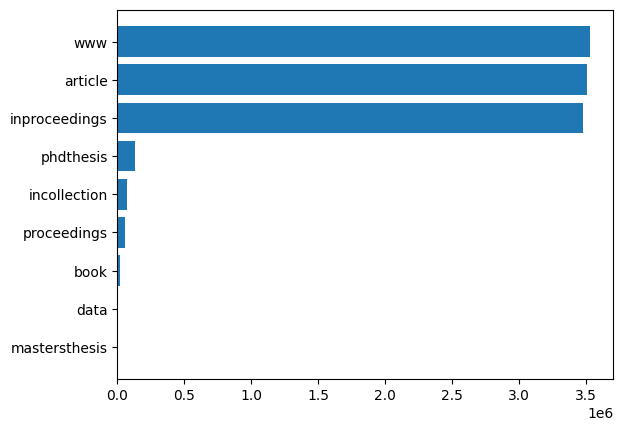

In [5]:
import matplotlib.pyplot as plt


with sqlite3.connect(path_to_db) as conn:
    df = pd.read_sql(sql="SELECT type, COUNT(*) as cnt FROM dblp GROUP BY type;", con=conn)
    df.sort_values("cnt", inplace=True, ascending=True)
    display(df)
    plt.barh(df["type"], df["cnt"])

Видим, что больше всего в базе статей из журналов, конференций и веб-страниц.

#### 2.2 Найдем сколько работ имеют DOI (это будет полезно нам в дальнейшем)

In [18]:
with sqlite3.connect(path_to_db) as conn:
    df = pd.read_sql(sql="""
        SELECT COUNT(*) as cnt
        FROM dblp
        WHERE ee LIKE 'https://doi.org/%'
      ;""", con=conn)
    display(df)

,cnt
0,4874921


Больше половины работ отсекаются по этому критерию.

#### 2.3 Найдем распределение работ по годам.

,year,cnt
0,None,3527793
1,1936,12
2,1937,16
3,1938,11
4,1939,18
...,...,...
86,2021,462950
87,2022,480564
88,2023,506430
89,2024,155958


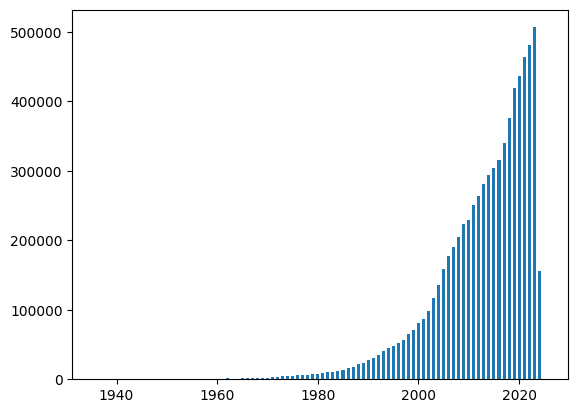

In [31]:
with sqlite3.connect(path_to_db) as conn:
    df = pd.read_sql(sql="""
        SELECT year, COUNT(*) as cnt
        FROM dblp
        GROUP BY year
      ;""", con=conn)
    display(df)

    df.dropna(inplace=True)
    plt.bar(df["year"].astype(int), height=df["cnt"], width=0.6)

In [17]:
with sqlite3.connect(path_to_db) as conn:
    df = pd.read_sql(sql="""
      SELECT type, key, author, title, year, ee AS doi
      FROM dblp
      WHERE
        ee LIKE 'https://doi.org/%'
        AND year >= 2015
        AND type IN ('article', 'inproceedings', 'phdthesis')
      ;""", con=conn)
    display(df)

,type,key,author,title,year,doi
0,inproceedings,conf/dac/LiuZWCYHYJ22,Li Jiang 0002,SATO: spiking neural network acceleration via ...,2022,https://doi.org/10.1145/3489517.3530592
1,inproceedings,conf/dac/AhnYLHKP20,Yunheung Paek,Hawkware: Network Intrusion Detection based on...,2020,https://doi.org/10.1109/DAC18072.2020.9218559
2,inproceedings,conf/dac/ZhangDV22,Naveen Verma,Statistical computing framework and demonstrat...,2022,https://doi.org/10.1145/3489517.3530557
3,inproceedings,conf/dac/LeeCY22,Joon-Sung Yang,Bipolar vector classifier for fault-tolerant d...,2022,https://doi.org/10.1145/3489517.3530498
4,inproceedings,conf/dac/LiuLLWY20,Chengmo Yang,Monitoring the Health of Emerging Neural Netwo...,2020,https://doi.org/10.1109/DAC18072.2020.9218675
...,...,...,...,...,...,...
2722770,phdthesis,phd/basesearch/Ahmadinejad16,Seyed Hossein Ahmadinejad,A View-Based Protection Model to Prevent Infer...,2016,https://doi.org/10.11575/PRISM/25087
2722771,phdthesis,phd/basesearch/Wang23b,Chenguang Wang 0006,Anomaly Detection and Synthetic Data Generatio...,2023,https://doi.org/10.4233/uuid:12708aca-dff2-4d5...
2722772,phdthesis,phd/basesearch/Informatica18a,Stefano Esposito,Mixed-Criticality Systems on Commercial-Off-th...,2018,https://doi.org/10.6092/polito/porto/2706773
2722773,phdthesis,phd/basesearch/He22a,Xiaoxi He,Towards On-Device Intelligence.,2022,https://doi.org/10.3929/ethz-b-000581224
